In [1]:
import numpy as np
import itertools
import json

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration, _sigmoid_calibration
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score, generate_corruptions_for_eval
from sklearn.metrics import brier_score_loss, log_loss, accuracy_score
from scipy.special import expit

from ampligraph.datasets import load_yago39k
from ampligraph.latent_features.models import TransE, ComplEx, DistMult

/home/ptabacof/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ptabacof/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ptabacof/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ptabacof/miniconda3/envs/py37/lib/pyt

In [2]:
from generate_corruptions import generate_corruptions, calibration_loss, pos_iso
import types

In [3]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [4]:
X = load_yago39k()

In [5]:
X_valid_pos = X['valid'][X['valid_labels']]
X_valid_neg = X['valid'][~X['valid_labels']]

X_test_pos = X['test'][X['test_labels']]
X_test_neg = X['test'][~X['test_labels']]

In [6]:
results = []

for eta in [1, 5, 10, 20, 50, 100]:
    model = TransE(batches_count=64, seed=0, epochs=500, k=100, eta=eta,
                   optimizer='adam', optimizer_params={'lr':0.0001},
                   loss='self_adversarial', verbose=False)

    model.fit(X['train'])
    
    scores = model.predict(X['test'])

    model.calibrate(X_valid_pos, batches_count=10, epochs=1000, positive_base_rate=0.5)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X['test'])

    model.calibrate(X_valid_pos, X_valid_neg)
    print("pos neg", model.calibration_parameters)
    probas2 = model.predict_proba(X['test'])
    
    val_scores = model.predict(X['valid'])
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
    probas3 = ir.predict(np.squeeze(scores).astype(float))
    
    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X_valid_pos))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=0.5)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))
    
    val_neg_scores = np.squeeze(model.predict(X_valid_neg))
    sc_pos_neg = pos_iso(_SigmoidCalibration(), val_pos_scores, val_neg_scores, positive_base_rate=0.5)
    print("pos neg sc", sc_pos_neg.a_, sc_pos_neg.b_)
    probas6 = sc_pos_neg.predict(np.squeeze(scores).astype(float))
    
    thresholds = {r: np.median(np.sort(val_scores[X['valid'][:, 1] == r])) for r in np.unique(X['valid'][:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(X['test'][:, 1])
    per_relation_acc = accuracy_score(X['test_labels'], scores > thresholds_test)

    acc_uncalib = accuracy_score(X['test_labels'], expit(scores) > 0.5)
    
    acc1 = accuracy_score(X['test_labels'], probas1 > 0.5)
    acc2 = accuracy_score(X['test_labels'], probas2 > 0.5)
    acc3 = accuracy_score(X['test_labels'], probas3 > 0.5)
    acc4 = accuracy_score(X['test_labels'], probas4 > 0.5)
    acc5 = accuracy_score(X['test_labels'], probas5 > 0.5)
    acc6 = accuracy_score(X['test_labels'], probas6 > 0.5)
    
    filter_triples = np.concatenate((X['train'], X_valid_pos, X_test_pos))
    ranks = evaluate_performance(X_test_pos, 
                                 model=model, 
                                 filter_triples=filter_triples,
                                 use_default_protocol=True, 
                                 verbose=False)

    results.append({
        'eta': eta,
        'brier_score_scores': brier_score_loss(X['test_labels'], expit(scores)),
        'log_loss_scores': log_loss(X['test_labels'], expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X['test_labels'], probas1),
        'log_loss_probas_pos': log_loss(X['test_labels'], probas1, eps=1e-7),
        'brier_score_probas_pos_neg': brier_score_loss(X['test_labels'], probas2),
        'log_loss_probas_pos_neg': log_loss(X['test_labels'], probas2, eps=1e-7),
        'brier_score_probas_pos_neg_iso': brier_score_loss(X['test_labels'], probas3),
        'log_loss_probas_pos_neg_iso': log_loss(X['test_labels'], probas3, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X['test_labels'], probas4),
        'log_loss_probas_pos_iso': log_loss(X['test_labels'], probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X['test_labels'], probas5),
        'log_loss_probas_pos_sc': log_loss(X['test_labels'], probas5, eps=1e-7),
        'brier_score_probas_pos_neg_sc': brier_score_loss(X['test_labels'], probas6),
        'log_loss_probas_pos_neg_sc': log_loss(X['test_labels'], probas6, eps=1e-7),
        'ece_scores': calibration_loss(X['test_labels'], expit(scores)),
        'ece_probas_pos': calibration_loss(X['test_labels'], probas1),
        'ece_probas_pos_neg': calibration_loss(X['test_labels'], probas2),
        'ece_probas_pos_neg_iso': calibration_loss(X['test_labels'], probas3),
        'ece_probas_pos_iso': calibration_loss(X['test_labels'], probas4),
        'ece_probas_pos_sc': calibration_loss(X['test_labels'], probas5),
        'ece_probas_pos_neg_sc': calibration_loss(X['test_labels'], probas6),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks),
        'accuracy_per_relation': per_relation_acc,
        'accuracy_uncalib': acc_uncalib,
        'accuracy_pos': acc1,
        'accuracy_pos_neg': acc2,
        'accuracy_pos_neg_iso': acc3,
        'accuracy_pos_iso': acc4,
        'accuracy_pos_sc': acc5,
        'accuracy_pos_neg_sc': acc6
    })
        
    print(json.dumps(results[-1], indent=2))

WARNING - From /home/ptabacof/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /home/ptabacof/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
WARNING - From /home/ptabac

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 1,
  "brier_score_scores": 0.2990559140977404,
  "log_loss_scores": 0.8533753190168981,
  "brier_score_probas_pos": 0.1793695196562365,
  "log_loss_probas_pos": 0.6217442041904955,
  "brier_score_probas_pos_neg": 0.13218414399234976,
  "log_loss_probas_pos_neg": 0.4212749407605009,
  "brier_score_probas_pos_neg_iso": 0.13048563145514833,
  "log_loss_probas_pos_neg_iso": 0.4143615840728662,
  "brier_score_probas_pos_iso": 0.1527224858050792,
  "log_loss_probas_pos_iso": 0.5030190435696197,
  "brier_score_probas_pos_sc": 0.15431488096096554,
  "log_loss_probas_pos_sc": 0.5083974498343258,
  "brier_score_probas_pos_neg_sc": 0.1321642372326723,
  "log_loss_probas_pos_neg_sc": 0.42128005152320125,
  "ece_scores": 0.3435801598333543,
  "ece_probas_pos": 0.18783596777146863,
  "ece_probas_pos_neg": 0.024200219595304096,
  "ece_probas_pos_neg_iso": 5.607820062555562e-17,
  "ece_probas_pos_iso": 0.1315325121706406,
  "ece_probas_pos_sc": 0.13351991459044382,
  "ece_probas_pos_neg_sc"

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 5,
  "brier_score_scores": 0.34528902873824724,
  "log_loss_scores": 1.0110212914630807,
  "brier_score_probas_pos": 0.1260717220242072,
  "log_loss_probas_pos": 0.4524452504662497,
  "brier_score_probas_pos_neg": 0.10485670021253662,
  "log_loss_probas_pos_neg": 0.3480773005279511,
  "brier_score_probas_pos_neg_iso": 0.1024246558914235,
  "log_loss_probas_pos_neg_iso": 0.33608305246786163,
  "brier_score_probas_pos_iso": 0.1200533231058073,
  "log_loss_probas_pos_iso": 0.4106759007191926,
  "brier_score_probas_pos_sc": 0.11757243812919507,
  "log_loss_probas_pos_sc": 0.4262617791410005,
  "brier_score_probas_pos_neg_sc": 0.10480886718538521,
  "log_loss_probas_pos_neg_sc": 0.34808128034103286,
  "ece_scores": 0.3932910451581401,
  "ece_probas_pos": 0.13067740901823963,
  "ece_probas_pos_neg": 0.03166622613065987,
  "ece_probas_pos_neg_iso": 8.147604454910422e-18,
  "ece_probas_pos_iso": 0.10553369324496893,
  "ece_probas_pos_sc": 0.10534841053346755,
  "ece_probas_pos_neg_s

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 10,
  "brier_score_scores": 0.35656060512892135,
  "log_loss_scores": 1.0448345374712196,
  "brier_score_probas_pos": 0.11884129466603793,
  "log_loss_probas_pos": 0.42166652313396036,
  "brier_score_probas_pos_neg": 0.09947706109924412,
  "log_loss_probas_pos_neg": 0.33245125134258974,
  "brier_score_probas_pos_neg_iso": 0.09718826173722865,
  "log_loss_probas_pos_neg_iso": 0.3215299212665093,
  "brier_score_probas_pos_iso": 0.1143667314431139,
  "log_loss_probas_pos_iso": 0.39234928243264144,
  "brier_score_probas_pos_sc": 0.11145270870740012,
  "log_loss_probas_pos_sc": 0.40609973206659034,
  "brier_score_probas_pos_neg_sc": 0.09943155610838189,
  "log_loss_probas_pos_neg_sc": 0.33245505391780167,
  "ece_scores": 0.4029007300510201,
  "ece_probas_pos": 0.12358212952972746,
  "ece_probas_pos_neg": 0.029282826249317488,
  "ece_probas_pos_neg_iso": 5.628711356029691e-18,
  "ece_probas_pos_iso": 0.10089033022580358,
  "ece_probas_pos_sc": 0.10037840766511119,
  "ece_probas_po

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 20,
  "brier_score_scores": 0.36331046007384304,
  "log_loss_scores": 1.0654467326192334,
  "brier_score_probas_pos": 0.11550019731786418,
  "log_loss_probas_pos": 0.4059832635650728,
  "brier_score_probas_pos_neg": 0.09678979310246702,
  "log_loss_probas_pos_neg": 0.32415147957012436,
  "brier_score_probas_pos_neg_iso": 0.09467836041780162,
  "log_loss_probas_pos_neg_iso": 0.3144029928619323,
  "brier_score_probas_pos_iso": 0.11196909501521446,
  "log_loss_probas_pos_iso": 0.3837659756737727,
  "brier_score_probas_pos_sc": 0.10864917338192398,
  "log_loss_probas_pos_sc": 0.395223295699695,
  "brier_score_probas_pos_neg_sc": 0.09674426656519954,
  "log_loss_probas_pos_neg_sc": 0.3241551278717746,
  "ece_scores": 0.4082523699729673,
  "ece_probas_pos": 0.12004646137196529,
  "ece_probas_pos_neg": 0.027690628215830813,
  "ece_probas_pos_neg_iso": 5.6320688853380336e-18,
  "ece_probas_pos_iso": 0.0988233098209118,
  "ece_probas_pos_sc": 0.09794909529338669,
  "ece_probas_pos_ne

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 50,
  "brier_score_scores": 0.3676594571673992,
  "log_loss_scores": 1.0783644888880795,
  "brier_score_probas_pos": 0.11307345267481257,
  "log_loss_probas_pos": 0.3952676755781392,
  "brier_score_probas_pos_neg": 0.09488501114432661,
  "log_loss_probas_pos_neg": 0.31796037188960363,
  "brier_score_probas_pos_neg_iso": 0.09277460228630839,
  "log_loss_probas_pos_neg_iso": 0.30878024530404685,
  "brier_score_probas_pos_iso": 0.10984176360655028,
  "log_loss_probas_pos_iso": 0.3763797317763427,
  "brier_score_probas_pos_sc": 0.1064855568609413,
  "log_loss_probas_pos_sc": 0.38695187125657166,
  "brier_score_probas_pos_neg_sc": 0.0948438786457997,
  "log_loss_probas_pos_neg_sc": 0.3179638618545876,
  "ece_scores": 0.41162901396392493,
  "ece_probas_pos": 0.11762942324402512,
  "ece_probas_pos_neg": 0.025683001446467568,
  "ece_probas_pos_neg_iso": 6.1032421649420565e-18,
  "ece_probas_pos_iso": 0.09681611759501087,
  "ece_probas_pos_sc": 0.09602103226429565,
  "ece_probas_pos_

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


In [7]:
eta_results = results

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

In [106]:
df=pd.DataFrame(eta_results)
df.columns

Index(['eta', 'brier_score_scores', 'log_loss_scores',
       'brier_score_probas_pos', 'log_loss_probas_pos',
       'brier_score_probas_pos_neg', 'log_loss_probas_pos_neg',
       'brier_score_probas_pos_neg_iso', 'log_loss_probas_pos_neg_iso',
       'brier_score_probas_pos_iso', 'log_loss_probas_pos_iso',
       'brier_score_probas_pos_sc', 'log_loss_probas_pos_sc',
       'brier_score_probas_pos_neg_sc', 'log_loss_probas_pos_neg_sc',
       'ece_scores', 'ece_probas_pos', 'ece_probas_pos_neg',
       'ece_probas_pos_neg_iso', 'ece_probas_pos_iso', 'ece_probas_pos_sc',
       'ece_probas_pos_neg_sc', 'metrics_mrr', 'metrics_hits@10', 'metrics_mr',
       'accuracy_per_relation', 'accuracy_uncalib', 'accuracy_pos',
       'accuracy_pos_neg', 'accuracy_pos_neg_iso', 'accuracy_pos_iso',
       'accuracy_pos_sc', 'accuracy_pos_neg_sc'],
      dtype='object')

In [107]:
df.to_csv("yago39k_eta.csv", index=False)

Text(0.5, 1.0, 'YAGO39K')

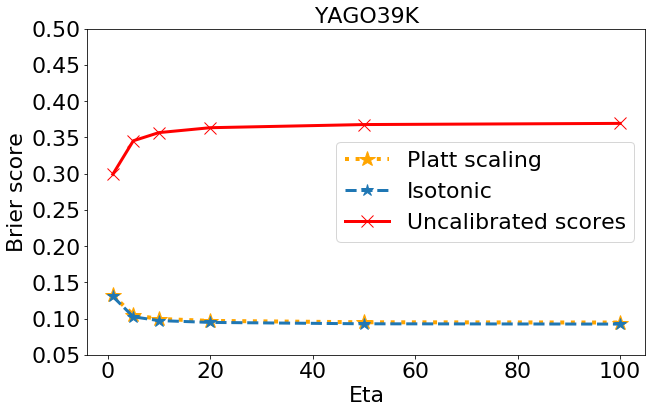

In [108]:
plt.rcParams.update({'font.size': 22, 'axes.titlesize': 22})

fig, ax1 = plt.subplots(figsize=(10, 6))

ln1 = ax1.plot(df.eta, df.brier_score_probas_pos_neg, "*:", lw=4, label="Platt scaling", color='orange', fillstyle='full',  markersize=16)
ln2 = ax1.plot(df.eta, df.brier_score_probas_pos_neg_iso, "*--", lw=3, label="Isotonic", color='tab:blue', fillstyle='full', markersize=12)
ln3 = ax1.plot(df.eta, df.brier_score_scores, "x-", lw=3, label="Uncalibrated scores", color='r', fillstyle='full',  markersize=12)
ax1.set_yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.xlabel("Eta")
plt.ylabel("Brier score")

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ln4 = ax2.plot(df.eta, df.metrics_mrr, "o--", lw=3, label="MRR", color='black', fillstyle='full', markersize=12)
# ax2.set_yticks([0.05, 0.10, 0.15, 0.20])

# lns = ln1+ln2+ln3+ln4
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc=0)

# plt.ylabel("MRR")
ax1.legend()
plt.title("YAGO39K")

In [12]:
results = []

for k in [10, 25, 50, 100, 200, 500]:
    model = TransE(batches_count=64, seed=0, epochs=500, k=k, eta=20,
                   optimizer='adam', optimizer_params={'lr':0.0001},
                   loss='self_adversarial', verbose=False)

    model.fit(X['train'])
    
    scores = model.predict(X['test'])

    model.calibrate(X_valid_pos, batches_count=10, epochs=1000, positive_base_rate=0.5)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X['test'])

    model.calibrate(X_valid_pos, X_valid_neg)
    print("pos neg", model.calibration_parameters)
    probas2 = model.predict_proba(X['test'])
    
    val_scores = model.predict(X['valid'])
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
    probas3 = ir.predict(np.squeeze(scores).astype(float))
    
    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X_valid_pos))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=0.5)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))
    
    val_neg_scores = np.squeeze(model.predict(X_valid_neg))
    sc_pos_neg = pos_iso(_SigmoidCalibration(), val_pos_scores, val_neg_scores, positive_base_rate=0.5)
    print("pos neg sc", sc_pos_neg.a_, sc_pos_neg.b_)
    probas6 = sc_pos_neg.predict(np.squeeze(scores).astype(float))
    
    thresholds = {r: np.median(np.sort(val_scores[X['valid'][:, 1] == r])) for r in np.unique(X['valid'][:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(X['test'][:, 1])
    per_relation_acc = accuracy_score(X['test_labels'], scores > thresholds_test)

    acc_uncalib = accuracy_score(X['test_labels'], expit(scores) > 0.5)
    
    acc1 = accuracy_score(X['test_labels'], probas1 > 0.5)
    acc2 = accuracy_score(X['test_labels'], probas2 > 0.5)
    acc3 = accuracy_score(X['test_labels'], probas3 > 0.5)
    acc4 = accuracy_score(X['test_labels'], probas4 > 0.5)
    acc5 = accuracy_score(X['test_labels'], probas5 > 0.5)
    acc6 = accuracy_score(X['test_labels'], probas6 > 0.5)
    
    filter_triples = np.concatenate((X['train'], X_valid_pos, X_test_pos))
    ranks = evaluate_performance(X_test_pos, 
                                 model=model, 
                                 filter_triples=filter_triples,
                                 use_default_protocol=True, 
                                 verbose=False)

    results.append({
        'k': k,
        'brier_score_scores': brier_score_loss(X['test_labels'], expit(scores)),
        'log_loss_scores': log_loss(X['test_labels'], expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X['test_labels'], probas1),
        'log_loss_probas_pos': log_loss(X['test_labels'], probas1, eps=1e-7),
        'brier_score_probas_pos_neg': brier_score_loss(X['test_labels'], probas2),
        'log_loss_probas_pos_neg': log_loss(X['test_labels'], probas2, eps=1e-7),
        'brier_score_probas_pos_neg_iso': brier_score_loss(X['test_labels'], probas3),
        'log_loss_probas_pos_neg_iso': log_loss(X['test_labels'], probas3, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X['test_labels'], probas4),
        'log_loss_probas_pos_iso': log_loss(X['test_labels'], probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X['test_labels'], probas5),
        'log_loss_probas_pos_sc': log_loss(X['test_labels'], probas5, eps=1e-7),
        'brier_score_probas_pos_neg_sc': brier_score_loss(X['test_labels'], probas6),
        'log_loss_probas_pos_neg_sc': log_loss(X['test_labels'], probas6, eps=1e-7),
        'ece_scores': calibration_loss(X['test_labels'], expit(scores)),
        'ece_probas_pos': calibration_loss(X['test_labels'], probas1),
        'ece_probas_pos_neg': calibration_loss(X['test_labels'], probas2),
        'ece_probas_pos_neg_iso': calibration_loss(X['test_labels'], probas3),
        'ece_probas_pos_iso': calibration_loss(X['test_labels'], probas4),
        'ece_probas_pos_sc': calibration_loss(X['test_labels'], probas5),
        'ece_probas_pos_neg_sc': calibration_loss(X['test_labels'], probas6),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks),
        'accuracy_per_relation': per_relation_acc,
        'accuracy_uncalib': acc_uncalib,
        'accuracy_pos': acc1,
        'accuracy_pos_neg': acc2,
        'accuracy_pos_neg_iso': acc3,
        'accuracy_pos_iso': acc4,
        'accuracy_pos_sc': acc5,
        'accuracy_pos_neg_sc': acc6
    })
        
    print(json.dumps(results[-1], indent=2))

pos [-2.2265592, -7.1046042]
pos neg [-1.6097322, -4.1296706]
pos sc -2.2157818274465333 -6.870233294253944
pos neg sc -1.6091756837939293 -4.136514768712605


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 10,
  "brier_score_scores": 0.3881301548692927,
  "log_loss_scores": 1.1479811242968971,
  "brier_score_probas_pos": 0.21087157812388668,
  "log_loss_probas_pos": 0.6712917028349181,
  "brier_score_probas_pos_neg": 0.1679678425742554,
  "log_loss_probas_pos_neg": 0.5183563915630227,
  "brier_score_probas_pos_neg_iso": 0.16569198568475413,
  "log_loss_probas_pos_neg_iso": 0.5065998667425536,
  "brier_score_probas_pos_iso": 0.19936661479733456,
  "log_loss_probas_pos_iso": 0.6344236475853993,
  "brier_score_probas_pos_sc": 0.2004858307479497,
  "log_loss_probas_pos_sc": 0.6349063681094692,
  "brier_score_probas_pos_neg_sc": 0.16797514387942336,
  "log_loss_probas_pos_neg_sc": 0.5183629181879411,
  "ece_scores": 0.40884494027783796,
  "ece_probas_pos": 0.1934425747779108,
  "ece_probas_pos_neg": 0.02721264090589299,
  "ece_probas_pos_neg_iso": 8.481119032872415e-18,
  "ece_probas_pos_iso": 0.16721007005094451,
  "ece_probas_pos_sc": 0.1701796383257645,
  "ece_probas_pos_neg_sc": 

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 25,
  "brier_score_scores": 0.3606955343457574,
  "log_loss_scores": 1.063843565577956,
  "brier_score_probas_pos": 0.13555863434069126,
  "log_loss_probas_pos": 0.4665928813372316,
  "brier_score_probas_pos_neg": 0.1127772062644637,
  "log_loss_probas_pos_neg": 0.3680612659083178,
  "brier_score_probas_pos_neg_iso": 0.1114150423014135,
  "log_loss_probas_pos_neg_iso": 0.36156440102695536,
  "brier_score_probas_pos_iso": 0.13272534929501362,
  "log_loss_probas_pos_iso": 0.44264236383417377,
  "brier_score_probas_pos_sc": 0.12953150886212267,
  "log_loss_probas_pos_sc": 0.4506519100079698,
  "brier_score_probas_pos_neg_sc": 0.11274729476379826,
  "log_loss_probas_pos_neg_sc": 0.3680655987563235,
  "ece_scores": 0.4037202330558531,
  "ece_probas_pos": 0.13098890817293554,
  "ece_probas_pos_neg": 0.022652928342101395,
  "ece_probas_pos_neg_iso": 5.885375818711851e-18,
  "ece_probas_pos_iso": 0.1154068356660611,
  "ece_probas_pos_sc": 0.11285323336316044,
  "ece_probas_pos_neg_sc"

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 50,
  "brier_score_scores": 0.36282695822293637,
  "log_loss_scores": 1.0671204833167458,
  "brier_score_probas_pos": 0.12039678930906902,
  "log_loss_probas_pos": 0.42153884115004886,
  "brier_score_probas_pos_neg": 0.1009473232599931,
  "log_loss_probas_pos_neg": 0.3356534045312356,
  "brier_score_probas_pos_neg_iso": 0.09903714111065143,
  "log_loss_probas_pos_neg_iso": 0.3267555582176944,
  "brier_score_probas_pos_iso": 0.11714583581383385,
  "log_loss_probas_pos_iso": 0.39894322016802736,
  "brier_score_probas_pos_sc": 0.11376725728151636,
  "log_loss_probas_pos_sc": 0.409777748568905,
  "brier_score_probas_pos_neg_sc": 0.10090570088988549,
  "log_loss_probas_pos_neg_sc": 0.3356571947002978,
  "ece_scores": 0.4073210773673109,
  "ece_probas_pos": 0.12304204387049521,
  "ece_probas_pos_neg": 0.027644773913967982,
  "ece_probas_pos_neg_iso": 4.575193270834314e-18,
  "ece_probas_pos_iso": 0.1030619957052602,
  "ece_probas_pos_sc": 0.10167004821350849,
  "ece_probas_pos_neg_s

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 100,
  "brier_score_scores": 0.3633293211549909,
  "log_loss_scores": 1.0654043909068618,
  "brier_score_probas_pos": 0.11537814718377395,
  "log_loss_probas_pos": 0.40568862908650305,
  "brier_score_probas_pos_neg": 0.0967287602170461,
  "log_loss_probas_pos_neg": 0.3239790021227338,
  "brier_score_probas_pos_neg_iso": 0.09456247561893844,
  "log_loss_probas_pos_neg_iso": 0.314096385016978,
  "brier_score_probas_pos_iso": 0.11178638030070571,
  "log_loss_probas_pos_iso": 0.38315664376783987,
  "brier_score_probas_pos_sc": 0.10855269716350517,
  "log_loss_probas_pos_sc": 0.39496579205259635,
  "brier_score_probas_pos_neg_sc": 0.09668589731732384,
  "log_loss_probas_pos_neg_sc": 0.3239826918266249,
  "ece_scores": 0.40827423034175747,
  "ece_probas_pos": 0.11992914507465978,
  "ece_probas_pos_neg": 0.027360191755397365,
  "ece_probas_pos_neg_iso": 1.0036774279070972e-17,
  "ece_probas_pos_iso": 0.09866054821112016,
  "ece_probas_pos_sc": 0.09784799991284783,
  "ece_probas_pos_n

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 200,
  "brier_score_scores": 0.3635631394119229,
  "log_loss_scores": 1.0637755300562832,
  "brier_score_probas_pos": 0.11327393922886776,
  "log_loss_probas_pos": 0.39931180783557474,
  "brier_score_probas_pos_neg": 0.09486970554759261,
  "log_loss_probas_pos_neg": 0.31860164037874494,
  "brier_score_probas_pos_neg_iso": 0.09264182115528229,
  "log_loss_probas_pos_neg_iso": 0.30811260576769994,
  "brier_score_probas_pos_iso": 0.10921037276491935,
  "log_loss_probas_pos_iso": 0.37602547524801916,
  "brier_score_probas_pos_sc": 0.10615512519210255,
  "log_loss_probas_pos_sc": 0.38888561043432596,
  "brier_score_probas_pos_neg_sc": 0.0948237102681143,
  "log_loss_probas_pos_neg_sc": 0.3186052292244847,
  "ece_scores": 0.4086347875287456,
  "ece_probas_pos": 0.11924715513824137,
  "ece_probas_pos_neg": 0.029109695598643313,
  "ece_probas_pos_neg_iso": 7.42536259480481e-18,
  "ece_probas_pos_iso": 0.0960702599422565,
  "ece_probas_pos_sc": 0.09628419070131117,
  "ece_probas_pos_ne

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


In [13]:
k_results = results

In [109]:
df=pd.DataFrame(k_results)
df.columns

Index(['k', 'brier_score_scores', 'log_loss_scores', 'brier_score_probas_pos',
       'log_loss_probas_pos', 'brier_score_probas_pos_neg',
       'log_loss_probas_pos_neg', 'brier_score_probas_pos_neg_iso',
       'log_loss_probas_pos_neg_iso', 'brier_score_probas_pos_iso',
       'log_loss_probas_pos_iso', 'brier_score_probas_pos_sc',
       'log_loss_probas_pos_sc', 'brier_score_probas_pos_neg_sc',
       'log_loss_probas_pos_neg_sc', 'ece_scores', 'ece_probas_pos',
       'ece_probas_pos_neg', 'ece_probas_pos_neg_iso', 'ece_probas_pos_iso',
       'ece_probas_pos_sc', 'ece_probas_pos_neg_sc', 'metrics_mrr',
       'metrics_hits@10', 'metrics_mr', 'accuracy_per_relation',
       'accuracy_uncalib', 'accuracy_pos', 'accuracy_pos_neg',
       'accuracy_pos_neg_iso', 'accuracy_pos_iso', 'accuracy_pos_sc',
       'accuracy_pos_neg_sc'],
      dtype='object')

In [103]:
df.to_csv("yago39k_k.csv", index=False)

Text(0.5, 1.0, 'YAGO39K')

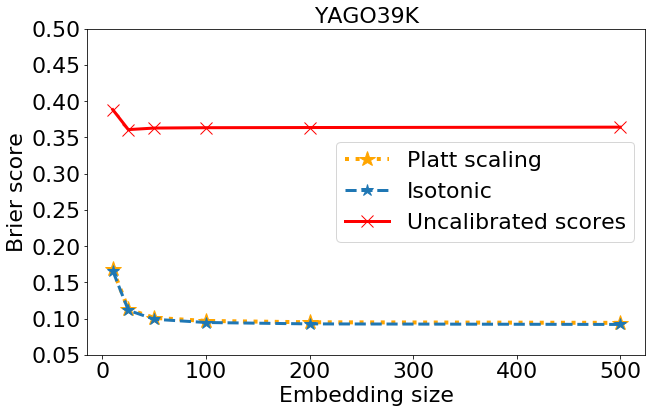

In [104]:
plt.rcParams.update({'font.size': 22, 'axes.titlesize': 22})


fig, ax1 = plt.subplots(figsize=(10, 6))

ln1 = ax1.plot(df.k, df.brier_score_probas_pos_neg, "*:", lw=4, label="Platt scaling", color='orange', fillstyle='full',  markersize=16)
ln2 = ax1.plot(df.k, df.brier_score_probas_pos_neg_iso, "*--", lw=3, label="Isotonic", color='tab:blue', fillstyle='full', markersize=12)
ln3 = ax1.plot(df.k, df.brier_score_scores, "x-", lw=3, label="Uncalibrated scores", color='r', fillstyle='full',  markersize=12)
ax1.set_yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
plt.xlabel("Embedding size")
plt.ylabel("Brier score")

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ln4 = ax2.plot(df.k, df.metrics_mrr, "o--", lw=3, label="MRR", color='black', fillstyle='full', markersize=12)
# ax2.set_yticks([0.05, 0.10, 0.15, 0.20])


# lns = ln1+ln2+ln3+ln4
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc=0)

# plt.ylabel("MRR")
ax1.legend()

plt.title("YAGO39K")